# Customer Lifetime Value
Project for analyzing customers worth in a company. This helps for customer segmentation - where we can tune different business strategies for different customer groups. 

Goals: 
1. To understand which customers to focus on.
2. Predict how much customers will likely spend in the future.
3. Predict the probabilty of customers making a purchase in the future.

## 0. About the dataset
The dataset is based on cdnow sales of new customers who signed-on or made their first purchases during 1997-01-01 to 1997-03-25. 

## 1. Data Preperation
Importing the dataset to understand it and clean it if needed.

In [1]:
# importing the libraries
import numpy as np
import pandas as pd
import joblib

# graphing libraries
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator  # for formatting axes based on dates
import seaborn as sns

# time calculations
from datetime import timedelta
import time

# machine learning libraries
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

# machine learning model evaluations
from sklearn.metrics import mean_absolute_error, mean_squared_error    # for regression model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix    # classification model eval

In [2]:
# importing the dataset
column_names = ["customer_id", "date", "quantity", "price"]
df = pd.read_table('dataset/CDNOW_master.txt', sep='\s+', names=column_names)

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_12119/1836189230.py:3: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_table('dataset/CDNOW_master.txt', sep='\s+', names=column_names)


In [3]:
df.head()

,customer_id,date,quantity,price
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  int64  
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


In [5]:
# converting date column into datetime64
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  69659 non-null  int64         
 1   date         69659 non-null  datetime64[ns]
 2   quantity     69659 non-null  int64         
 3   price        69659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.1 MB


In [7]:
df.head()

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76


In [8]:
# verifying for duplicates
df[df.duplicated(keep=False)].shape

(470, 4)

In [9]:
dups = df[df.duplicated(keep=False)]
dups.sort_values('customer_id').head(10)

,customer_id,date,quantity,price
1380,398,1998-05-18,1,12.99
1381,398,1998-05-18,1,12.99
1711,499,1997-10-29,1,9.49
1712,499,1997-10-29,1,9.49
1713,499,1997-10-29,1,9.49
1715,499,1997-10-29,1,9.49
1717,499,1997-10-29,1,11.49
1718,499,1997-10-29,1,11.49
1720,499,1997-10-29,1,19.99
1721,499,1997-10-29,1,9.99


Visually inspecting we can see that there are *some* duplicated rows - but these are justified - customers' purchases can be tallied individually per item.

This is valied since the dataset is based on cdnow, a cd retail service during the dotcom bubble. The "duplicate" purchases could very well be "1 CD of similar price, each listed in its own row"

No cleaning needed. Good to go. May do further transformations later as needed during exploratory data analysis.

## 2. Exploratory Data Analysis
Taking a look at the dataset

### 2.1 Overall Analysis
Taking a look at the overall dataset

In [10]:
df.describe()

,customer_id,date,quantity,price
count,69659.000000,69659,69659.000000,69659.000000
mean,11470.854592,1997-07-02 22:36:51.401254656,2.410040,35.893648
min,1.000000,1997-01-01 00:00:00,1.000000,0.000000
25%,5506.000000,1997-02-22 00:00:00,1.000000,14.490000
50%,11410.000000,1997-04-24 00:00:00,2.000000,25.980000
75%,17273.000000,1997-11-07 00:00:00,3.000000,43.700000
max,23570.000000,1998-06-30 00:00:00,99.000000,1286.010000
std,6819.904848,NaN,2.333924,36.281942


69659 rows, but 23570 customer_ids - this indicates there are repeat purchases. Min quantity is 1 meaning all customers in this list made at least 1 purchase/transaction. Min price of 0 indicates that there are some purchases that are free.

In [11]:
# checking out the max number of items purchased (quantity == 99)
max_quantity = df['quantity'].max()
print(df[df['quantity'] == max_quantity])

       customer_id       date  quantity    price
27632         8830 1998-06-10        99  1286.01


In [12]:
# checking out the largest single transaction (price == 1286.01)
max_price = df['price'].max()
print(df[df['price'] == max_price])

       customer_id       date  quantity    price
27632         8830 1998-06-10        99  1286.01


In [13]:
# checking out the $0 transactions
min_price = df['price'].min()
print(df[df['price'] == min_price])

       customer_id       date  quantity  price
1548           455 1997-01-02         1    0.0
2446           713 1997-01-03         1    0.0
3066           908 1997-01-04         1    0.0
3118           925 1997-01-04         1    0.0
3623          1101 1997-01-05         1    0.0
...            ...        ...       ...    ...
65701        22173 1997-03-19         1    0.0
67706        22848 1997-03-22         1    0.0
68013        22950 1997-03-23         1    0.0
68076        22979 1997-03-23         1    0.0
68593        23157 1997-03-24         1    0.0

[80 rows x 4 columns]


In [14]:
# taking a look at purchase trends over time
# looking at sum of spend and sum of quantities per by date
df_sum_date = df.groupby('date')[['quantity', 'price']].sum()
df_sum_date = df_sum_date.rename(columns={'quantity': 'quantity_sum', 'price': 'price_sum'})

In [15]:
df_sum_date.head()

,quantity_sum,price_sum
date,,
1997-01-01,494,7515.35
1997-01-02,530,8025.95
1997-01-03,495,7475.04
1997-01-04,404,6722.93
1997-01-05,590,9274.80


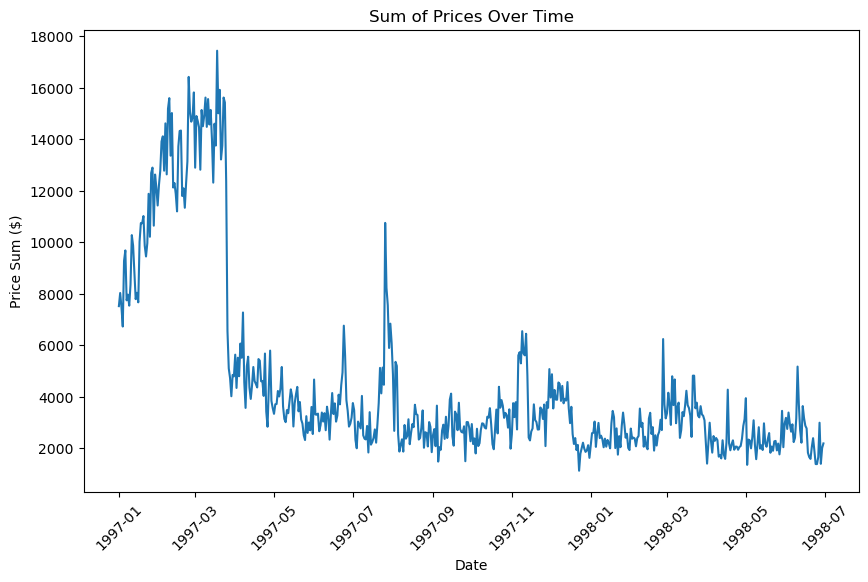

In [16]:
# making a plot to see the sum of spend over time
# restting the index to make date a column again
df_sum_date.reset_index()

# createing the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_sum_date, x='date', y='price_sum')

# rotating the xticks for readability
plt.xticks(rotation=45)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Price Sum ($)')
plt.title('Sum of Prices Over Time')

plt.show()

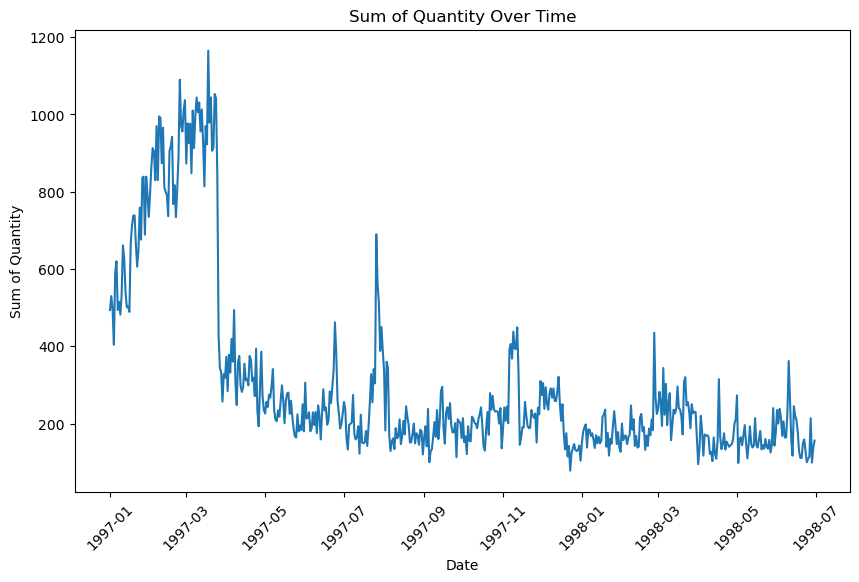

In [17]:
# plotting sum of quantity of purchases over time

#createing the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_sum_date, x='date', y='quantity_sum')

# rotating the xticks for readability
plt.xticks(rotation=45)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Sum of Quantity')
plt.title('Sum of Quantity Over Time')

plt.show()

The pattern of sum quantity purchased and sum price purchased look practically identical.

### 2.2 Cohort Analysis
Taking a look at customers who first purchased in the 1997 Jan to 1997 Mar period (new customers). This is called cohort analysis - because they are subject to similar conditions when they first purchased.

In [18]:
# getting range of initial purchases
df_first_purchase = df.groupby('customer_id').min().sort_values(['customer_id', 'date'])

In [19]:
df_first_purchase

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,1,16.99
4,1997-01-01,1,14.96
5,1997-01-01,1,13.97
...,...,...,...
23566,1997-03-25,2,36.00
23567,1997-03-25,1,20.97
23568,1997-03-25,1,14.99


In [20]:
df_first_purchase.describe()

,date,quantity,price
count,23570,23570.000000,23570.000000
mean,1997-02-12 21:45:13.517182976,1.689902,24.710771
min,1997-01-01 00:00:00,1.000000,0.000000
25%,1997-01-25 00:00:00,1.000000,11.990000
50%,1997-02-13 00:00:00,1.000000,15.360000
75%,1997-03-05 00:00:00,2.000000,28.930000
max,1997-03-25 00:00:00,40.000000,1119.680000
std,NaN,1.533405,25.758258


In [21]:
# counting num unique customers in df_first_purchase and df
print(df_first_purchase.index.nunique())
print(df['customer_id'].nunique())

23570
23570


Verified that the dataset indeed only captures customers who first signed-on during 1997-01-01 to 1997-03-25

### 2.3 Visualizing Some Customers: Individual Purchases

In [22]:
ids = df['customer_id'].unique()

# masking a mask to pick 10 customer_ids - arbritrary selection - can be any number so desired
ids_selected = ids[0:10]

df_cust_selected = df[df['customer_id'].isin(ids_selected)]
df_cust_selected_sum = df_cust_selected.groupby(['customer_id', 'date']).sum()

In [23]:
df_cust_selected_sum.head()

quantity  price
customer_id date                       
1           1997-01-01         1  11.77
2           1997-01-12         6  89.00
3           1997-01-02         2  20.76
            1997-03-30         2  20.76
            1997-04-02         2  19.54

NameError: name 'ax' is not defined

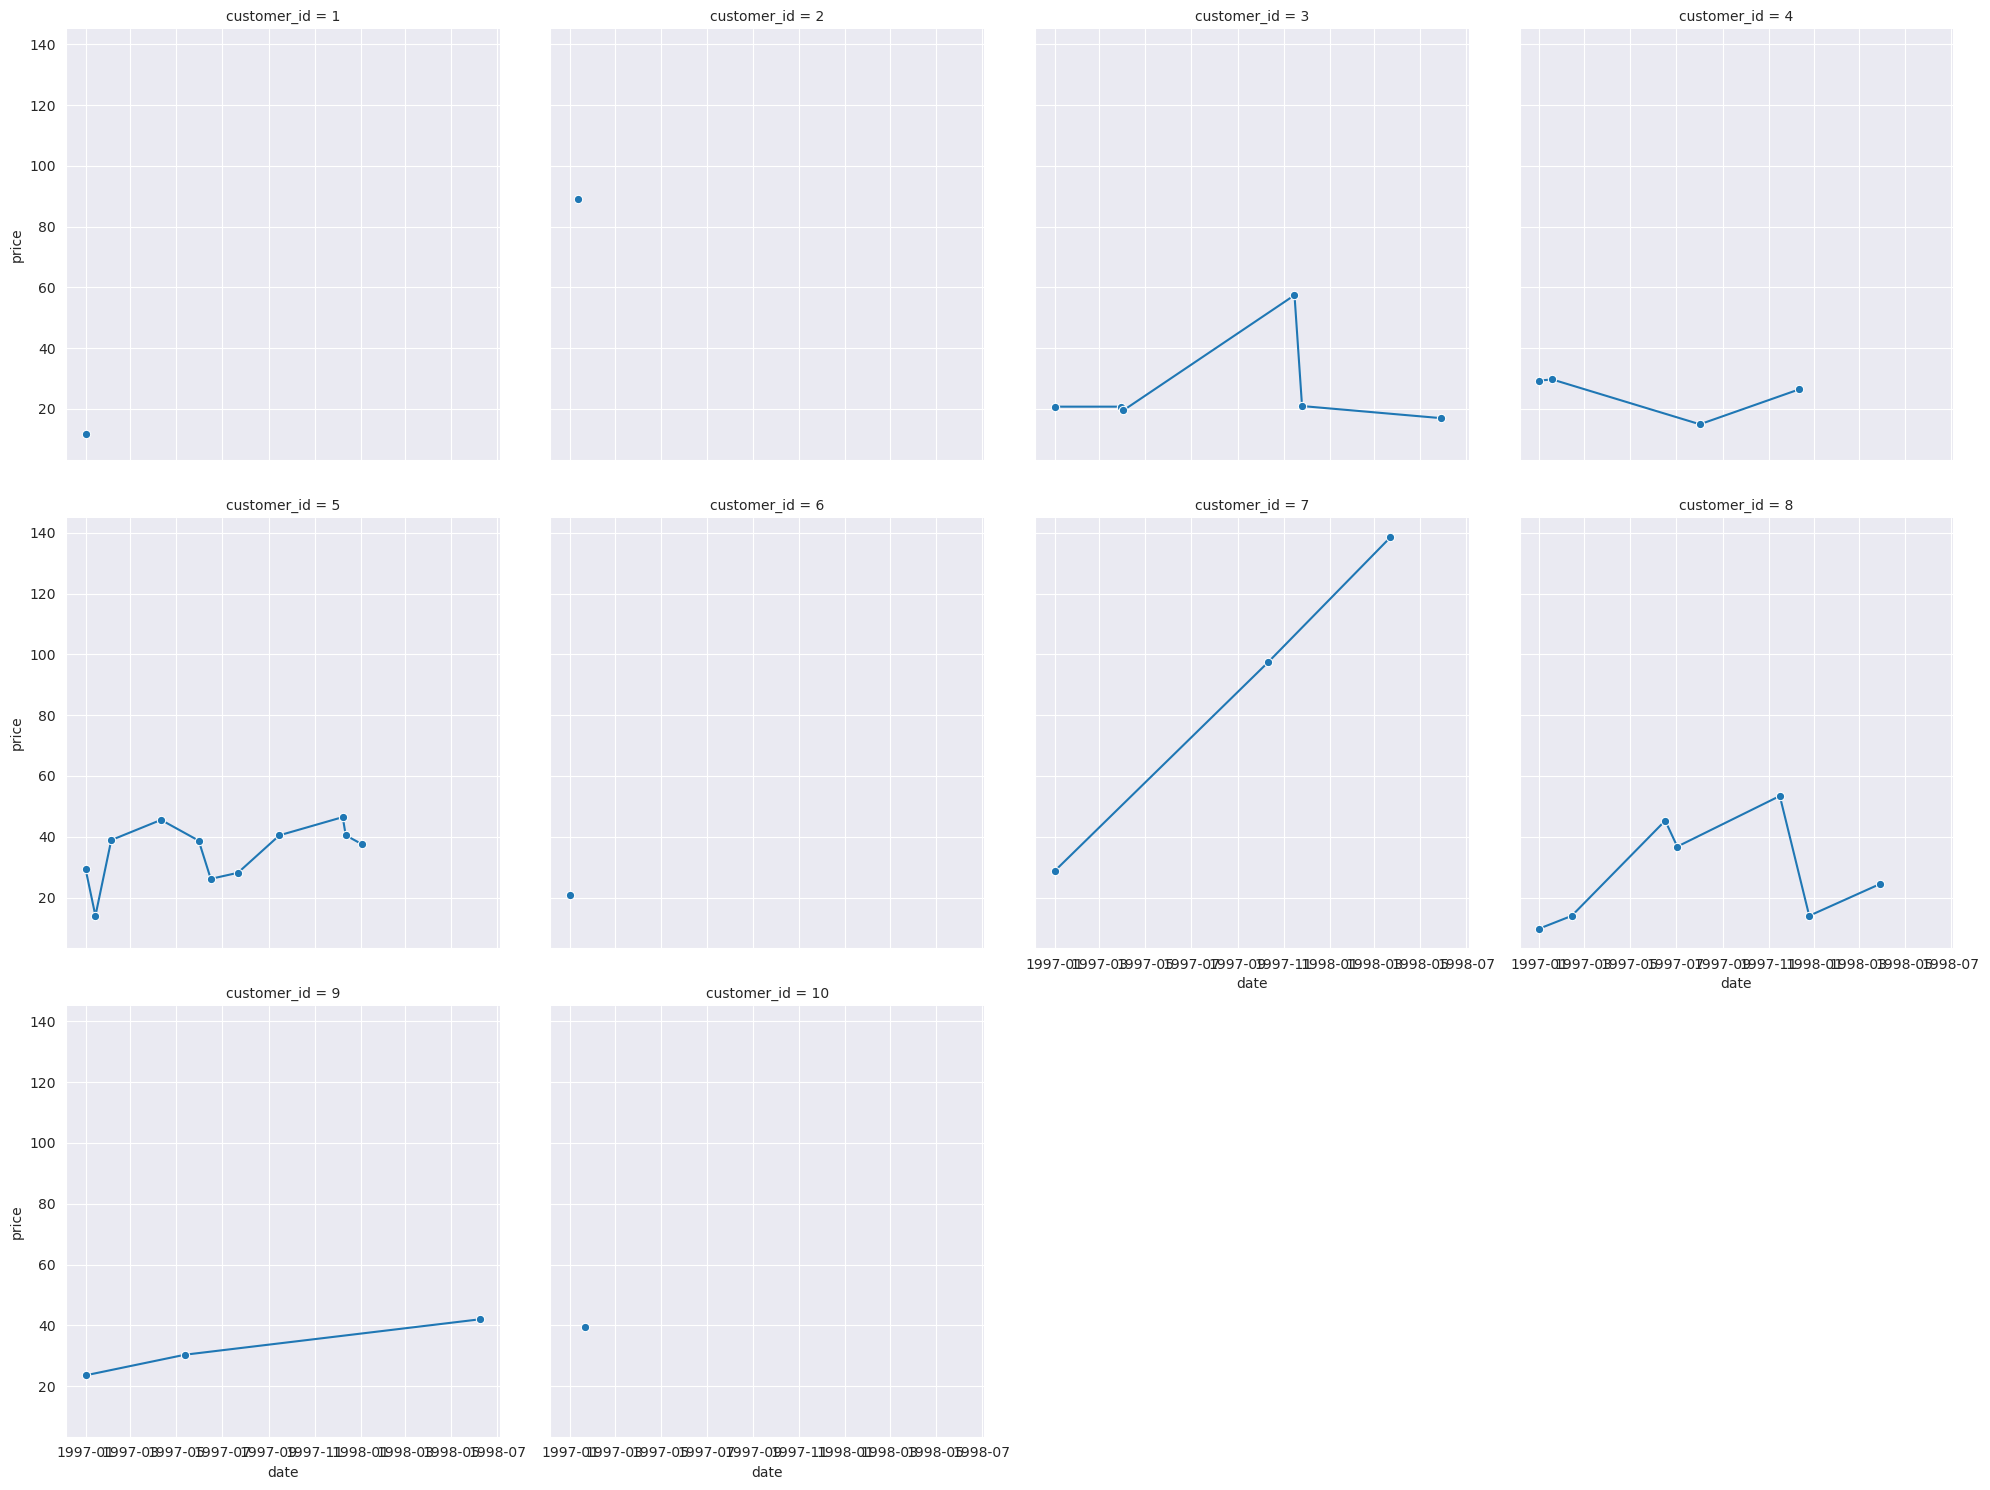

In [24]:
# making an sns line plot for each customer 
# parition with subplot

# sets style
sns.set_style("darkgrid")

# Plot 
sns.relplot(data=df_cust_selected_sum, x='date', y='price',
           col='customer_id', col_wrap=4,
           kind='line', marker='o')

ax.set_title('Sum of Price per Day')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(title='Customer ID')

plt.show()

Some things we can notice: customer 1, 2, 10 only bought once and that's it. These customers have a low chance of shopping ever again.

Customer 3 shows some promise, so things like discounts can spur them to buy more. These types of customers have a good likelihood to be long term customers. 

Customers 4, 5, 8 are dying customers - where they have frequent activity, and suddenly their activity stops. Maybe they left for other services etc. These are the customers we want to stop from leaving.

## 3. Machine Learning
This portion is where machine learning is done

The things we want to know:
1. What will the customers spend in the next 90 days? (regression)
2. What is the probability of a customer to make a purchase in the next 90 days? (classification)

### 3.1 Time splitting
We're essentially making the dataset in which we want to predict future outcomes (our target dataset). We apply the trained model onto this.

We're also making our training set (and will further split that into test set).

In [25]:
# we want to predict 90 days into the future 
n_days = 30
cutoff = df['date'].max() - timedelta(days=n_days)

# will use these 2 for boolean masking for making the features and targets in the next section
temporal_out_df = df[df['date'] > cutoff]
temporal_in_df = df[df['date'] <= cutoff]

### 3.2 Feature Engineering
This section shows the feature creation step. This is especially important since the original dataset in its raw form is not necessarily useful for training models.

Special note: Feature engineering is especially important for XGBoost models.

In [26]:
# making the targets
targets_df = temporal_out_df.drop(['quantity', 'date'], axis=1)\
    .groupby('customer_id')\
    .sum()\
    .rename({'price' : 'spend_90_total'}, axis=1)\
    .assign(spend_90_flag=1)

In [27]:
targets_df.reset_index()

,customer_id,spend_90_total,spend_90_flag
0,9,41.98,1
1,25,49.95,1
2,47,12.99,1
3,48,38.97,1
4,64,37.56,1
...,...,...,...
1501,23444,21.22,1
1502,23489,9.99,1
1503,23513,28.99,1
1504,23555,27.48,1


In [28]:
# making the features
max_date = temporal_in_df['date'].max()

# calculating recency for each customer_id
# trying to find how recent their last puchase was from max_date
def recency_func(df):
    last_purchase = (df['date'].max() - max_date).days
    return (pd.DataFrame({'recency':[last_purchase]}))

# making recency features
recency_features_df = temporal_in_df.groupby('customer_id')[['customer_id', 'date']].apply(recency_func).reset_index()
recency_features_df.drop(columns='level_1', inplace=True)

In [29]:
# making frequency features
# how frequent is this customer making purchases

frequency_features_df = temporal_in_df.groupby('customer_id').count().reset_index().rename(columns={'date': 'frequency'})
frequency_features_df.drop(columns=['quantity', 'price'], inplace=True)

In [30]:
# making monetary features
# sum and average

# doing it this way instead of making a dict inside agg will result in a flat df - easier for merging
# e.g. .agg({'price': ['sumn', 'mean']}) will have multi index
price_features_df = temporal_in_df.groupby('customer_id')['price'].agg(['sum', 'mean']).reset_index()
price_features_df.rename(columns={'sum': 'price_sum', 'mean': 'price_mean'}, inplace=True)

In [31]:
price_features_df.head()

,customer_id,price_sum,price_mean
0,1,11.77,11.770000
1,2,89.00,44.500000
2,3,156.46,26.076667
3,4,100.50,25.125000
4,5,385.61,35.055455


In [32]:
# merging (join) the created targets and features
features_df = recency_features_df.merge(frequency_features_df, on='customer_id', how='inner')\
    .merge(price_features_df, on='customer_id', how='inner')\
    .merge(targets_df, on='customer_id', how='left').fillna(0)  # left join here results in nan values. plugging these with 0

features_df.head(10)

,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
0,1,-515,1,11.77,11.770000,0.00,0.0
1,2,-504,2,89.00,44.500000,0.00,0.0
2,3,-3,6,156.46,26.076667,0.00,0.0
3,4,-170,4,100.50,25.125000,0.00,0.0
4,5,-148,11,385.61,35.055455,0.00,0.0
5,6,-515,1,20.99,20.990000,0.00,0.0
6,7,-70,3,264.67,88.223333,0.00,0.0
7,8,-63,8,197.66,24.707500,0.00,0.0
8,9,-383,2,53.87,26.935000,41.98,1.0
9,10,-495,1,39.31,39.310000,0.00,0.0


In [33]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23570 entries, 0 to 23569
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     23570 non-null  int64  
 1   recency         23570 non-null  int64  
 2   frequency       23570 non-null  int64  
 3   price_sum       23570 non-null  float64
 4   price_mean      23570 non-null  float64
 5   spend_90_total  23570 non-null  float64
 6   spend_90_flag   23570 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 1.3 MB


In [34]:
# changing spend_90_flag into cat dtype
features_df['spend_90_flag'] = features_df['spend_90_flag'].astype('category')

## 4. Business questions + machine learning
Some questions a business can ask about this dataset (about their customers)

1. Which customers have the highest probability to spend in the next 90 days?
2. Which customers have recently purchased but are unlikely to buy?
3. Which customers are predicted to purchase but didn't (missed opportunities)?

### 4.1 Next 90 day Spend Prediction
This is a regression question to predict how much the customer would spend in the next 90 days

In [35]:
# setting up the variables
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]
y_spend = features_df['spend_90_total']

# splittin to text and train set
X_train, X_test, y_train, y_test = train_test_split(X, y_spend, test_size=0.2, random_state=1)

# creating the estimator for hyperparameter tuning
xgb_reg_spec = XGBRegressor(objective="reg:squarederror", random_state=123)

# creating the parameter grid for hyperparameter tuning
param_grid = {'learning_rate': [0.01, 0.1, 0.3, 0.5]}

# starting a timer
start_time = time.time()

# creating the regression model
xgb_reg_model = GridSearchCV(
    xgb_reg_spec, 
    param_grid,
    scoring = 'neg_mean_absolute_error',
    refit = True,
    cv = 5
)

# fitting the model
xgb_reg_model.fit(X_train, y_train)

# end timer
end_time = time.time()
train_time = end_time - start_time
print('Training time: %.4f seconds' % train_time)

Training time: 2.2059 seconds


In [36]:
# regression model's best score
best_score = xgb_reg_model.best_score_

# regressopm model's best params
best_params = xgb_reg_model.best_params_

# regression model's best estimators
xgb_reg_best_estimator = xgb_reg_model.best_estimator_

print('Best score: ', best_score)
print('Best paramaters: ', best_params)
#print('Best estimator(s): ', best_estimator)

Best score:  -4.807360088035572
Best paramaters:  {'learning_rate': 0.1}


In [37]:
# comparing y_train and y_test
y_pred = xgb_reg_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 4.895973911678672
Mean Absolute Percentage Error (MAPE): inf
Mean Squared Error (MSE): 938.0952700367741
Root Mean Squared Error (RMSE): 30.628340961220445


In [38]:
print(np.mean(y_test))

3.305659736953755


MAE of 4.89 dollars is comparable to the average of 3.31 dollars in y_test. This is fairly good. 
A RMSE of 30.63 dollars means that there are some outliers in either y_test or y_pred, making the value large. 

No point comparing them together, since it's like comparing apple to oranges; best to compare to MAE and RMSE in another model

In [39]:
# using the entire feature set for fitting the model
xgb_reg_best_estimator.fit(X, y_spend)

prediction_reg = xgb_reg_best_estimator.predict(X)
# in reality for this step, predict using new data that we want to use to make predictions

### 4.2 Next 90 days spend probability
This is a classification problem (spend or no spend) to predict if customers will spend in the next 90 days.

In [40]:
# setting up the features and target variables
# X is the same as above
y_prob = features_df['spend_90_flag']

# splittin to text and train set
X_train, X_test, y_train, y_test = train_test_split(X, y_prob, test_size=0.2, random_state=1)

# creating the estimator for hyperparameter tuning
xgb_class_spec = XGBClassifier(objective="binary:logistic", random_state=123)

# creating the parameter grid for hyperparameter tuning
param_grid = {'learning_rate': [0.01, 0.1, 0.3, 0.5]}

# starting a timer
start_time = time.time()

# creating the classifier model
xgb_clf_model = GridSearchCV(
    xgb_class_spec, 
    param_grid,
    scoring = 'roc_auc',
    refit = True,
    cv = 5
)

# fitting the model
xgb_clf_model.fit(X_train, y_train)

# stopping the timer
end_time = time.time()
train_time = end_time - start_time
print('Training time: %.4f seconds' % train_time)

Training time: 1.9652 seconds


In [41]:
# classification model's best score
best_score = xgb_clf_model.best_score_

# regressopm model's best params
best_params = xgb_clf_model.best_params_

# regression model's best estimators
xgb_clf_best_estimator = xgb_clf_model.best_estimator_

print('Best score: ', best_score)
print('Best paramaters: ', best_params)
# print('Best estimator(s): ', xgb_clf_estimator)

Best score:  0.8466939167453477
Best paramaters:  {'learning_rate': 0.01}


Best score of 0.847 is pretty good. Much better than random guessing. Basically 84% of the time we can predict if the person will be purchasing or not.

In [42]:
# comparing y_train and y_test
y_pred = xgb_clf_model.predict(X_test)

# metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
# alternatively use sklearn-metrics classification_report

# Printing Metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.9416631310988545
Precision: 0.8
Recall: 0.028469750889679714
F1 Score: 0.054982817869415807
ROC AUC Score: 0.5140092945740977


In [43]:
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[4431    2]
 [ 273    8]]


Notice that the recall and F1 score are attrocious. An ROC AUC score of 0.51 suggests that this model is just basically just randomly guessing. 

Note for scikit-learns' confusion matrix:

[TN FP]

[FN TP]

In [44]:
# Calculate True Negatives
tn = conf_matrix[0, 0]

# Calculate False Positives
fp = conf_matrix[0, 1]

# Calculate False Positive Rate (FPR)
fpr = fp / (fp + tn)

# Calculate True Negative Rate (TNR) or Specificity
tnr = tn / (tn + fp)

# Printing FPR and TNR
print("False Positive Rate (FPR):", fpr)
print("True Negative Rate (TNR) or Specificity:", tnr)

False Positive Rate (FPR): 0.00045116174148432213
True Negative Rate (TNR) or Specificity: 0.9995488382585157


Note that while the model does suck in guessing if a customer is true positive (will buy) or false negative (will not buy but predicted as will buy). False negative's correction is just that we offer some discounts or promotions to people who would've bought. It might cost a little money, but it's not as bad as false negatives (people who will not buy but guessed as leaving).

In this regard, the model is reasonably accurate. The inaccuracy of this model comes from false negative. 

In [45]:
# using the entire feature set for fitting the model
xgb_clf_best_estimator.fit(X, y_prob)

prediction_clf = xgb_clf_best_estimator.predict_proba(X)
# in reality for this step, predict using new data that we want to use to make predictions

### 4.3 Feature Importance
Getting the values, and understanding how important each feature is.

#### Feature importance: regression model (spend amount)

In [46]:
# gets a dict of features and their scores/weights
imp_spend_amount_dict = xgb_reg_best_estimator\
    .get_booster()\
    .get_score(importance_type = 'gain')  # get booster() is needed for get_score()
print(imp_spend_amount_dict)

{'recency': 6130.9599609375, 'frequency': 31348.142578125, 'price_sum': 22889.95703125, 'price_mean': 7721.97021484375}


In [47]:
# transforming into a df
# Convert the dictionary to a pandas Series
imp_spend_amount_series = pd.Series(imp_spend_amount_dict)

# Create a DataFrame from the Series by resetting the index
imp_spend_amount_df = imp_spend_amount_series.reset_index()

# Rename the columns
imp_spend_amount_df.columns = ['feature', 'importance']

# Sort the DataFrame by importance in descending order
imp_spend_amount_df = imp_spend_amount_df.sort_values('importance', ascending=False)

# Print the DataFrame
print(imp_spend_amount_df)

      feature    importance
1   frequency  31348.142578
2   price_sum  22889.957031
3  price_mean   7721.970215
0     recency   6130.959961


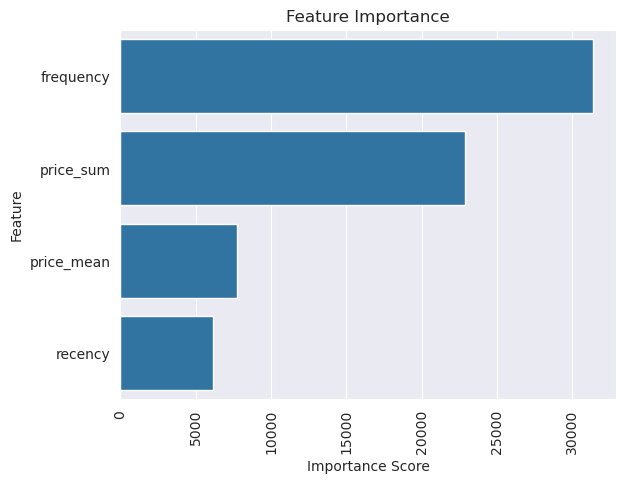

In [48]:
# plotting this
sns.barplot(x='importance', y='feature', data=imp_spend_amount_df, orient='h')

# axis labels and title
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')

# rotate xticks
plt.xticks(rotation=90)

# plot
plt.show()

The frequency of purchases of the customer is the most important feature, followed by their sum of purchase. Price mean and recency are both not as important. In fact by up to 3 times less important.

#### Feature importance: classifier model (spend probability)

In [49]:
# gets a dict of features and their scores/weights
imp_spend_proba_dict = xgb_clf_best_estimator\
    .get_booster()\
    .get_score(importance_type = 'gain')  # get booster() is needed for get_score()
print(imp_spend_proba_dict)

{'recency': 38.925113677978516, 'frequency': 45.240379333496094, 'price_sum': 2.6993753910064697, 'price_mean': 2.987555503845215}


In [50]:
# transforming into a df
# Convert the dictionary to a pandas Series
imp_spend_proba_series = pd.Series(imp_spend_proba_dict)

# Create a DataFrame from the Series by resetting the index
imp_spend_proba_df = imp_spend_proba_series.reset_index()

# Rename the columns
imp_spend_proba_df.columns = ['feature', 'importance']

# Sort the DataFrame by importance in descending order
imp_spend_proba_df = imp_spend_proba_df.sort_values('importance', ascending=False)

# Print the DataFrame
print(imp_spend_proba_df)

      feature  importance
1   frequency   45.240379
0     recency   38.925114
3  price_mean    2.987556
2   price_sum    2.699375


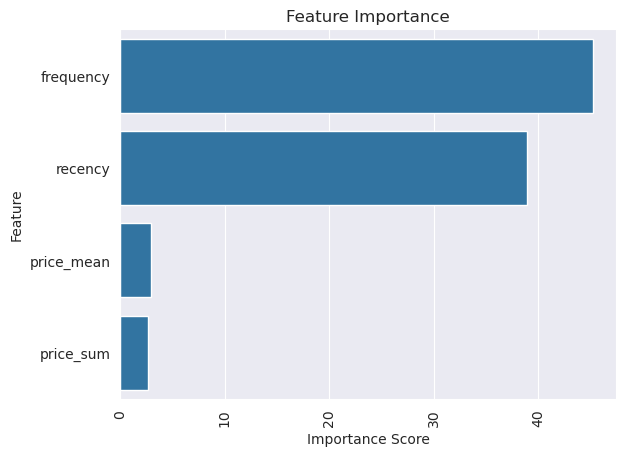

In [51]:
# plotting this
sns.barplot(x='importance', y='feature', data=imp_spend_proba_df, orient='h')

# axis labels and title
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')

# rotate xticks
plt.xticks(rotation=90)

# plot
plt.show()

For classifier, the frequency and recency are the most important features, whereas average purchase amount (price_mean) and sum are not as important. This checks out intuitively as well.

## 5. Saving the output

### 5.1 Saving the prediction output

In [52]:
# importing pickle to export the models as pickle files
import pickle

In [53]:
# transforming the predictions into df
prediction_reg_df = pd.DataFrame(prediction_reg)
prediction_clf_df = pd.DataFrame(prediction_clf)

# renameing the columns
prediction_reg_df.columns = ['pred_spend']
prediction_clf_df.columns = ['pred_proba_no', 'pred_proba']

# keeping only the "will spend" probability 
prediction_clf_df.drop('pred_proba_no', axis=1, inplace=True)

In [54]:
# merging with df_features
merge_df12 = features_df.merge(prediction_reg_df, left_index=True, right_index=True, how='outer')
prediction_df = merge_df12.merge(prediction_clf_df, left_index=True, right_index=True, how='outer')

In [55]:
prediction_df.head(10)

,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag,pred_spend,pred_proba
0,1,-515,1,11.77,11.770000,0.00,0.0,0.250941,0.059640
1,2,-504,2,89.00,44.500000,0.00,0.0,1.154008,0.060735
2,3,-3,6,156.46,26.076667,0.00,0.0,11.007883,0.218114
3,4,-170,4,100.50,25.125000,0.00,0.0,2.693627,0.122450
4,5,-148,11,385.61,35.055455,0.00,0.0,7.936677,0.189782
5,6,-515,1,20.99,20.990000,0.00,0.0,0.291104,0.059640
6,7,-70,3,264.67,88.223333,0.00,0.0,2.782984,0.098380
7,8,-63,8,197.66,24.707500,0.00,0.0,9.517196,0.215574
8,9,-383,2,53.87,26.935000,41.98,1.0,1.286039,0.088527
9,10,-495,1,39.31,39.310000,0.00,0.0,0.340324,0.059640


In [56]:
# exporting this as a csv
prediction_df.to_csv('output/output.csv', index=False)

In [57]:
# saving the predictions as a pickle file
prediction_df.to_pickle('artifacts/prediction_df.pkl')

### 5.2 Saving the feature importance

In [58]:
imp_spend_amount_df.to_pickle('artifacts/imp_spend_amount_df.pkl')
imp_spend_proba_df.to_pickle('artifacts/imp_spend_proba_df.pkl')

### 5.3 Saving the models

In [59]:
joblib.dump(xgb_reg_model, 'artifacts/xgb_reg_model.pkl')
joblib.dump(xgb_clf_model, 'artifacts/xgb_clf_model.pkl')

['artifacts/xgb_clf_model.pkl']

## 6. How to use this information?
Made the models and made the predictions. Now to answer the business questions.

### 6.1 Which customers have the highest probability to spend in the next 90 days?
These customers can be targeted with similar products to keep them buying.

In [62]:
prediction_df.sort_values('pred_proba', ascending=False)

,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag,pred_spend,pred_proba
12859,12860,-12,38,1677.41,44.142368,168.93,1.0,132.754715,0.569114
14047,14048,-3,206,8441.60,40.978641,534.73,1.0,531.442871,0.560937
7982,7983,-4,134,6583.43,49.130075,389.64,1.0,379.413239,0.560937
3048,3049,-7,106,3943.08,37.198868,319.77,1.0,323.331085,0.560937
1076,1077,-4,48,3286.43,68.467292,38.06,1.0,48.152725,0.560937
...,...,...,...,...,...,...,...,...,...
10440,10441,-478,1,5.99,5.990000,0.00,0.0,0.250941,0.059640
10441,10442,-478,1,11.77,11.770000,0.00,0.0,0.250941,0.059640
10443,10444,-478,1,15.90,15.900000,0.00,0.0,0.250941,0.059640
10444,10445,-478,1,42.30,42.300000,0.00,0.0,0.317891,0.059640


### 6.2 Which customers have recently purchased, but are unlikely to buy?
Could try to introduce steps/discounts/promos to retain their interest.

Possible actions:
* Discounts
* Friend referrals
* News updates

In [63]:
unlikely_buy_df = prediction_df[(prediction_df['recency'] > -90) & (prediction_df['pred_proba'] < 0.20)]
unlikely_buy_df_sorted = unlikely_buy_df.sort_values('pred_proba', ascending=False)

unlikely_buy_df_sorted.head()

,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag,pred_spend,pred_proba
12666,12667,-78,7,210.11,30.015714,0.0,0.0,9.389457,0.199877
9148,9149,-78,7,188.45,26.921429,0.0,0.0,9.389457,0.199877
23438,23439,-82,7,271.49,38.784286,0.0,0.0,10.797000,0.199720
9742,9743,-7,5,383.47,76.694000,0.0,0.0,13.303111,0.199679
8053,8054,-42,9,171.03,19.003333,0.0,0.0,5.303968,0.199467


### 6.3 Missed opportunities: Big spenders who were predicted to spend, but did not
These are spenders who could be nudged to make repeat purchases with some offers/discounts.

In [65]:
missed_oppor_df = prediction_df[prediction_df['spend_90_flag'] == 0].sort_values(['pred_spend', 'pred_proba'], ascending=False)
missed_oppor_df.head()

,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag,pred_spend,pred_proba
15623,15624,-151,10,519.40,51.940000,0.0,0.0,129.584015,0.247423
20399,20400,-19,10,521.01,52.101000,0.0,0.0,81.909134,0.265817
10822,10823,-71,12,618.15,51.512500,0.0,0.0,67.221176,0.351597
15378,15379,-83,4,485.95,121.487500,0.0,0.0,65.558678,0.100440
12844,12845,-53,14,719.92,51.422857,0.0,0.0,57.992054,0.351597
